In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import warnings
import numpy as np
import csv
from nltk import ngrams
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from collections import Counter
import string 
import re
from wordcloud import WordCloud, STOPWORDS
from PIL import Image
import datetime
import spacy
from scattertext import SampleCorpora, produce_scattertext_explorer
from scattertext import produce_scattertext_html
from scattertext.CorpusFromPandas import CorpusFromPandas
stopwords = set(STOPWORDS)
pd.options.display.max_colwidth = 400
warnings.filterwarnings('ignore')

### Data cleaning and Data Pre-Processing

* Read from csv file collected from data scraping
* Check for empty

### Function definitions
* Check data frame
* Clean data
* Plot data


In [2]:
def check_dataframe(df):
    """
    Function to check for empty rows or zeroes in rows for a dataframe
    df: input dataframe
    
    """
    print(f"Data frame shape: {df.shape}")
    nulls = {k:v for k,v in dict(df.isnull().sum()).items() if v>0}
    for k,v in nulls.items():
        print(f"Empty rows in column [{k}]: {v}")
    zeroes = {k:v for k,v in dict(df[df == 0].count()).items() if v>0}
    for k,v in zeroes.items():
        print(f"Rows with zeroes in column [{k}]: {v}")
    column_types = {str(k):list(v) for k,v in df.groupby(df.dtypes,axis=1)}
    for k,v in column_types.items():
        print(f"Columns with data type [{k}]:{v}")


In [3]:
def clean(text):
    """
    Removes characters from text for preprocessing:
    """
    
    # Replacing Two or more dots with one
    text = re.sub(r'\.{2,}', '.', text)
    
    # Removing all the special Characters
    text = re.sub(r'[^\w\d\s]', ' ', text)
    
    # Removing all the non ASCII characters
    text = re.sub(r'[^\x00-\x7F]+', ' ', text)
    
    # Removing the leading and trailing Whitespaces
    text = re.sub(r'^\s+|\s+?$', '', text)
    
    # Replacing multiple Spaces with Single Space
    text = re.sub(r'\s+',' ', text)
    
    # Removing numbers
    text = re.sub(r'\d+','', text)
    
    # Newlines (replaced with space to preserve cases like word1\nword2)
    text = re.sub(r'\n+', ' ', text)
    text = text.strip()
    text = re.sub(r'\s\s+', ' ', text)

    # > Quotes
    text = re.sub(r'\"?\\?&?gt;?', '', text)

    # Bullet points/asterisk (bold/italic)
    text = re.sub(r'\*', '', text)
    text = re.sub('&amp;#x200B;', '', text)

    # []() Link (Also removes the hyperlink)
    text = re.sub(r'\[.*?\]\(.*?\)', '', text)

    # Strikethrough
    text = re.sub('~', '', text)

    # Spoiler
    text = re.sub('&lt;', '', text)
    text = re.sub(r'!(.*?)!', r'\1', text)

    # Code, inline and block
    text = re.sub('`', '', text)

    # Superscript
    text = re.sub(r'\^\((.*?)\)', r'\1', text)

    # Table
    text = re.sub(r'\|', ' ', text)
    text = re.sub(':-', '', text)

    # Heading
    text = re.sub('#', '', text)

    return text

### Read data from CSV into dataframe

In [4]:
selected_columns = ['subreddit','selftext', 'author', 'title', 'score','num_comments','utc_datetime_str']

In [5]:
df_aws = pd.read_csv('../data/aws_subreddit.csv')[selected_columns]
df_az = pd.read_csv('../data/az_subreddit.csv')[selected_columns]

In [6]:
check_dataframe(df_aws)

Data frame shape: (4998, 7)
Empty rows in column [selftext]: 879
Rows with zeroes in column [score]: 27
Rows with zeroes in column [num_comments]: 4400
Columns with data type [int64]:['score', 'num_comments']
Columns with data type [object]:['subreddit', 'selftext', 'author', 'title', 'utc_datetime_str']


In [7]:
check_dataframe(df_az)

Data frame shape: (4996, 7)
Empty rows in column [selftext]: 972
Rows with zeroes in column [score]: 44
Rows with zeroes in column [num_comments]: 4099
Columns with data type [int64]:['score', 'num_comments']
Columns with data type [object]:['subreddit', 'selftext', 'author', 'title', 'utc_datetime_str']


### Check data before cleaning

In [8]:
pattern = re.compile('(?:(?:https?|ftp):\/\/)?[\w/\-?=%.]+\.[\w/\-&?=%.]+')
comment = str(df_aws.iloc[[4]]['selftext'])

print(f"Before: {comment}")
print(f"After: {pattern.sub('', comment)}")

Before: 4    Anyone here using Workload Discovery to build diagrams? We've been building a free alternative and I'd be interested to see what sort of things people actually use workload discovery for.\n\nWhat we're doing: [https://overmind.tech/blog/cloud-infrastructure-diagrams](https://overmind.tech/blog/cloud-infrastructure-diagrams)
Name: selftext, dtype: object
After: 4    Anyone here using Workload Discovery to build diagrams? We've been building a free alternative and I'd be interested to see what sort of things people actually use workload discovery for.\n\nWhat we're doing: []()
Name: selftext, dtype: object


In [9]:
df_aws[~df_aws['selftext'].isna()]

,subreddit,selftext,author,title,score,num_comments,utc_datetime_str
0,aws,[removed],BrianPRegan,AWS Pricing Add-on for Google Sheets,1,0,2023-03-10 16:28:11
1,aws,[removed],Winter_Sucks_7868,Kansas AWS,1,0,2023-03-10 15:52:40
2,aws,"We have a site to site VPN between our AWS and a fortigate. It's set to dynamic so BGP shares all the routes back and forth.\n\nWell there is one route that I can't get it to share over BGP. I have put it as a route statically in AWS and pointed it to the AWS tunnel but it won't pass.\n\nIf a aws VPN is set the ""dynamic"" will it only pass routes it learns via BGP? You can't add a static also?",silicondt,VPN - dynamic - can we put one static also?,1,0,2023-03-10 15:20:34
3,aws,"Hi,\n\nWhat would be the best instance for a ""Whisper"" machine ? (OpenAI's transcription program). I would need to use this machine for a few hours a month only and I need 10GB of VRAM (at least the ""large"" model).\n\nThanks",Juythar,"Best Instance for a ""Whisper"" Machine?",1,0,2023-03-10 14:30:25
4,aws,Anyone here using Workload Discovery to build diagrams? We've been building a free alternative and I'd be interested to see what sort of things people actually use workload discovery for.\n\nWhat we're doing: [https://overmind.tech/blog/cloud-infrastructure-diagrams](https://overmind.tech/blog/cloud-infrastructure-diagrams),jameslaney,"Anyone using Workload Discovery? We’re building an alternative, what features do people actually use?",1,0,2023-03-10 13:50:36
...,...,...,...,...,...,...,...
4988,aws,"We are doing some house cleaning and have some instances that appear to be unused. I'm unsure of how to find out when these instances were stopped. I suppose I could start each one in question and look at its logs, but there must be a better way.",PeterPanLives,How can I see when an instance was stopped?,4,8,2017-01-02 19:26:11
4990,aws,With the recent price drop of S3 Standard Storage to $0.023 it is now cheaper than the Reduced Redundancy Storage option that is still $0.024. Does anyone know what is going on? Are they trying to get rid of the RRS option?,FortLouie,Why is S3 RRS more expensive than standard?,3,4,2017-01-02 19:19:21
4991,aws,"Hi all, I'm working on this cfn template and running into an issue setting up a Conditional for an optional CommaDelimitedList parameter. When I run the following though, the API reports an error: *every Fn::Equals object requires a list of 2 string parameters.* \n\n Parameters:\n SomeParam:\n Description: &gt;-\n (Optional) Comma separated list of things.\n Type...",inhumantsar,CloudFormation Condition on CommaDelimitedList,7,9,2017-01-02 17:38:02
4996,aws,"**Happy New Year!** \n\nI've been working on collecting data for a while that is basically latency between all of the different AWS regions. There have been several times over the course of last year where I had been working with a client on trying to quantify latency between different AWS regions - I found lots of static, or old data, but nothing that was really up to date. \n\nSo I made this...",mda90,Latency Between AWS Regions monitoring tool,2,1,2017-01-02 01:04:13


In [10]:
df_az[~df_az['selftext'].isna()]

,subreddit,selftext,author,title,score,num_comments,utc_datetime_str
0,AZURE,This week's Azure Infrastructure Update is up.\n\nhttps://youtu.be/f\_e8E4HIQVA,JohnSavill,Azure Infrastructure Weekly Update - 10th March 2023,1,0,2023-03-10 14:17:31
1,AZURE,"Reposting for more favorable hours of the day...\n\nQuick and potentially dumb question...\n\nSetting up a GCC tenant + Azure Commercial for an AVD deployment. However, none of the government equivalent licenses include the Windows desktop entitlement for AVD.\n\nThere some secret sauce for getting that or is GCC a bust?",wheres_my_toast,AVD licensing in GCC?,1,0,2023-03-10 14:13:42
2,AZURE,Where is the best place to go for an issue with a GraphAPI. I am having issues with this one here: \n\n[https://graph.microsoft.com/{version}/sites/{id}/onenote/](https://graph.microsoft.com/{version}/sites/{id}/onenote/){notebooks | sections | sectionGroups | pages}\n\nWhen sending a GET request to [https://graph.microsoft.com/v1.0/sites/{id}/onenote/](https://graph.microsoft.com/{version}/s...,gschellhas,Issue with Graph API Endpoint: OneNote Sites,1,0,2023-03-10 14:10:53
3,AZURE,"Hi,\n\ni have the following permission in Microsoft Sentinel:\n\n* Microsoft Sentinel Playbook Operator\n* Microsoft Sentinel Automation Contributor\n* Microsoft Sentinel Contributor\n\nAnyway i can't create playbooks, i receive following error:\n\n*The client 'xxxxxxxxxxxxxxxx' with object id 'xxxxxxxxxxxxxxx' does not have authorization to perform action 'Microsoft.Logic/register/action' ove...",ivansk81,Azure Sentinel - Playbook Permission,1,0,2023-03-10 13:37:48
4,AZURE,"Hi,\n\ni have the following permission in Microsoft Sentinel:\n\n \n\n* Microsoft Sentinel Playbook Operator\n* Microsoft Sentinel Automation Contributor\n* Microsoft Sentinel Contributor\n\nAnyway i can't create playbooks, i receive following error. What im missing?",ivansk81,Microsoft Sentinel - Playbook Permissions,1,0,2023-03-10 13:34:17
...,...,...,...,...,...,...,...
4989,AZURE,I am setting up some azure accounts for the first time. I will have one server running .Net open to the internet. I will other servers for our SAP ERP system. I want to avoid the scenario where if our web facing server is hacked they can get access to our ERP server. Would I be safer to setup the Web and ERP servers under different Azure accounts?,chinguetti,"New to Azure. Safe to put webservers, ERP servers on same Azure account?",5,3,2016-04-17 09:25:47
4990,AZURE,[deleted],[deleted],"Database is in SSMS but ""not found"" error in the portal?",6,3,2016-04-16 19:34:54
4991,AZURE,"# Background\nWe are using azure for a SaaS I am building. Still in the early days with only a handful of users. The product is a .Net + SQL server + blob storage back end, and lots of typescript and less on the front end). We use code first migrations. Using Git-Flow workflow.\n\nWe want a 3 tier approach with dev/test/prod. Originally I had just set up a 3 DB’s on the same server, and use ...",snowsquirrel,"Could I get some feedback on my Azure usage, please.",4,3,2016-04-16 19:20:28
4992,AZURE,"Let's say I have a program on my PC/Server (veeam / shadowprotect) that is doing daily snapshots of my computer/server. I want to test this in conjunction with Windows Azure file / folder backup.\n\n*Retention policy - Assuming veeam / shadowprotect manage the backup jobs, retention policy should be set at 1 day on the azure backup jobs because my local backup software is handling the retentio...",yutz23,Windows Azure Backup Question(s),2,1,2016-04-15 23:37:01


### Combine title and description
* Some posts only have title

In [11]:
def combine_title_message(df):
    df['fullmessage'] = df['title'] + (' ' + df['selftext']).fillna('')
    return df

df_aws = combine_title_message(df_aws)
df_aws[df_aws['selftext'].isna()].head(3)

,subreddit,selftext,author,title,score,num_comments,utc_datetime_str,fullmessage
5,aws,NaN,MaxGanzII,Redshift Research Project : varbyte sorting (blog post),1,0,2023-03-10 13:06:15,Redshift Research Project : varbyte sorting (blog post)
7,aws,NaN,DodeYoke,Using AWS CLI to create and manage functions in Lambda,1,0,2023-03-10 11:58:20,Using AWS CLI to create and manage functions in Lambda
13,aws,NaN,Gleb--K,Amazon DynamoDB now supports table deletion protection,1,0,2023-03-10 07:49:00,Amazon DynamoDB now supports table deletion protection


In [12]:
df_az = combine_title_message(df_az)
df_az[df_az['selftext'].isna()].head(3)

,subreddit,selftext,author,title,score,num_comments,utc_datetime_str,fullmessage
20,AZURE,NaN,IAmTwoSixNine,Azure Front Door path mapping 404 aborted,1,0,2023-03-10 04:42:21,Azure Front Door path mapping 404 aborted
34,AZURE,NaN,NaViFanYearDntMatter,"Looking at the cost breakdown of a VM, what is the last row and what could be the reasons for it to be $0?",1,0,2023-03-09 15:52:39,"Looking at the cost breakdown of a VM, what is the last row and what could be the reasons for it to be $0?"
47,AZURE,NaN,Emma__24,Enable report suspicious activity in Azure AD to stay alerted on suspicious MFA requests!,1,0,2023-03-09 10:40:45,Enable report suspicious activity in Azure AD to stay alerted on suspicious MFA requests!


### Clean the posts 
* Url links
* Removed or Deleted
* newlines
* quotes
* bullet points
* Strikethrough
* Table
* Heading
* Spoilers
* Code, inline and block

In [13]:
def replace_text(df,col):
    df[col]=df[col].astype(str)
    pattern = re.compile('(?:(?:https?|ftp):\/\/)?[\w/\-?=%.]+\.[\w/\-&?=%.]+')
    df[col]=df[col].apply(lambda x: pattern.sub('', str(x)))
    df[col]=df[col].str.replace('\n', ' ')
    df[col]=df[col].str.replace('\[removed\]', '')
    df[col]=df[col].str.replace('\[deleted\]', '')
    df[col]=df[col].str.replace('\[\]\(\)', '') 
    df[col]=df[col].apply(lambda x: clean(str(x)))
    return df
    
df_aws = replace_text(df_aws,'fullmessage')
df_az = replace_text(df_az,'fullmessage')

In [14]:
df_aws[~df_aws['selftext'].isna()]

,subreddit,selftext,author,title,score,num_comments,utc_datetime_str,fullmessage
0,aws,[removed],BrianPRegan,AWS Pricing Add-on for Google Sheets,1,0,2023-03-10 16:28:11,AWS Pricing Add on for Google Sheets
1,aws,[removed],Winter_Sucks_7868,Kansas AWS,1,0,2023-03-10 15:52:40,Kansas AWS
2,aws,"We have a site to site VPN between our AWS and a fortigate. It's set to dynamic so BGP shares all the routes back and forth.\n\nWell there is one route that I can't get it to share over BGP. I have put it as a route statically in AWS and pointed it to the AWS tunnel but it won't pass.\n\nIf a aws VPN is set the ""dynamic"" will it only pass routes it learns via BGP? You can't add a static also?",silicondt,VPN - dynamic - can we put one static also?,1,0,2023-03-10 15:20:34,VPN dynamic can we put one static also We have a site to site VPN between our AWS and a fortigate It s set to dynamic so BGP shares all the routes back and forth Well there is one route that I can t get it to share over BGP I have put it as a route statically in AWS and pointed it to the AWS tunnel but it won t pass If a aws VPN is set the dynamic will it only pass routes it learns via BGP You...
3,aws,"Hi,\n\nWhat would be the best instance for a ""Whisper"" machine ? (OpenAI's transcription program). I would need to use this machine for a few hours a month only and I need 10GB of VRAM (at least the ""large"" model).\n\nThanks",Juythar,"Best Instance for a ""Whisper"" Machine?",1,0,2023-03-10 14:30:25,Best Instance for a Whisper Machine Hi What would be the best instance for a Whisper machine OpenAI s transcription program I would need to use this machine for a few hours a month only and I need GB of VRAM at least the large model Thanks
4,aws,Anyone here using Workload Discovery to build diagrams? We've been building a free alternative and I'd be interested to see what sort of things people actually use workload discovery for.\n\nWhat we're doing: [https://overmind.tech/blog/cloud-infrastructure-diagrams](https://overmind.tech/blog/cloud-infrastructure-diagrams),jameslaney,"Anyone using Workload Discovery? We’re building an alternative, what features do people actually use?",1,0,2023-03-10 13:50:36,Anyone using Workload Discovery We re building an alternative what features do people actually use Anyone here using Workload Discovery to build diagrams We ve been building a free alternative and I d be interested to see what sort of things people actually use workload discovery for What we re doing
...,...,...,...,...,...,...,...,...
4988,aws,"We are doing some house cleaning and have some instances that appear to be unused. I'm unsure of how to find out when these instances were stopped. I suppose I could start each one in question and look at its logs, but there must be a better way.",PeterPanLives,How can I see when an instance was stopped?,4,8,2017-01-02 19:26:11,How can I see when an instance was stopped We are doing some house cleaning and have some instances that appear to be unused I m unsure of how to find out when these instances were stopped I suppose I could start each one in question and look at its logs but there must be a better way
4990,aws,With the recent price drop of S3 Standard Storage to $0.023 it is now cheaper than the Reduced Redundancy Storage option that is still $0.024. Does anyone know what is going on? Are they trying to get rid of the RRS option?,FortLouie,Why is S3 RRS more expensive than standard?,3,4,2017-01-02 19:19:21,Why is S RRS more expensive than standard With the recent price drop of S Standard Storage to it is now cheaper than the Reduced Redundancy Storage option that is still Does anyone know what is going on Are they trying to get rid of the RRS option
4991,aws,"Hi all, I'm working on this cfn template and running into an issue setting up a Conditional for an optional CommaDelimitedList parameter. When I run the following though, the API reports an error: *every Fn::Equals object requires a list of 2 string parameters.* \n\n Param

### Check data after cleaning

In [15]:
df_az[~df_az['selftext'].isna()]

,subreddit,selftext,author,title,score,num_comments,utc_datetime_str,fullmessage
0,AZURE,This week's Azure Infrastructure Update is up.\n\nhttps://youtu.be/f\_e8E4HIQVA,JohnSavill,Azure Infrastructure Weekly Update - 10th March 2023,1,0,2023-03-10 14:17:31,Azure Infrastructure Weekly Update th March This week s Azure Infrastructure Update is up _eEHIQVA
1,AZURE,"Reposting for more favorable hours of the day...\n\nQuick and potentially dumb question...\n\nSetting up a GCC tenant + Azure Commercial for an AVD deployment. However, none of the government equivalent licenses include the Windows desktop entitlement for AVD.\n\nThere some secret sauce for getting that or is GCC a bust?",wheres_my_toast,AVD licensing in GCC?,1,0,2023-03-10 14:13:42,AVD licensing in GCC Reposting for more favorable hours of the Quick and potentially dumb Setting up a GCC tenant Azure Commercial for an AVD deployment However none of the government equivalent licenses include the Windows desktop entitlement for AVD There some secret sauce for getting that or is GCC a bust
2,AZURE,Where is the best place to go for an issue with a GraphAPI. I am having issues with this one here: \n\n[https://graph.microsoft.com/{version}/sites/{id}/onenote/](https://graph.microsoft.com/{version}/sites/{id}/onenote/){notebooks | sections | sectionGroups | pages}\n\nWhen sending a GET request to [https://graph.microsoft.com/v1.0/sites/{id}/onenote/](https://graph.microsoft.com/{version}/s...,gschellhas,Issue with Graph API Endpoint: OneNote Sites,1,0,2023-03-10 14:10:53,Issue with Graph API Endpoint OneNote Sites Where is the best place to go for an issue with a GraphAPI I am having issues with this one here version sites id onenote version sites id onenote notebooks sections sectionGroups pages When sending a GET request to id onenote version sites id onenote notebooks it returns a The OData query is invalid The URI segment notebooks is invalid after the seg...
3,AZURE,"Hi,\n\ni have the following permission in Microsoft Sentinel:\n\n* Microsoft Sentinel Playbook Operator\n* Microsoft Sentinel Automation Contributor\n* Microsoft Sentinel Contributor\n\nAnyway i can't create playbooks, i receive following error:\n\n*The client 'xxxxxxxxxxxxxxxx' with object id 'xxxxxxxxxxxxxxx' does not have authorization to perform action 'Microsoft.Logic/register/action' ove...",ivansk81,Azure Sentinel - Playbook Permission,1,0,2023-03-10 13:37:48,Azure Sentinel Playbook Permission Hi i have the following permission in Microsoft Sentinel Microsoft Sentinel Playbook Operator Microsoft Sentinel Automation Contributor Microsoft Sentinel Contributor Anyway i can t create playbooks i receive following error The client xxxxxxxxxxxxxxxx with object id xxxxxxxxxxxxxxx does not have authorization to perform action over scope subscriptions xxxxxx...
4,AZURE,"Hi,\n\ni have the following permission in Microsoft Sentinel:\n\n \n\n* Microsoft Sentinel Playbook Operator\n* Microsoft Sentinel Automation Contributor\n* Microsoft Sentinel Contributor\n\nAnyway i can't create playbooks, i receive following error. What im missing?",ivansk81,Microsoft Sentinel - Playbook Permissions,1,0,2023-03-10 13:34:17,Microsoft Sentinel Playbook Permissions Hi i have the following permission in Microsoft Sentinel Microsoft Sentinel Playbook Operator Microsoft Sentinel Automation Contributor Microsoft Sentinel Contributor Anyway i can t create playbooks i receive following error What im missing
...,...,...,...,...,...,...,...,...
4989,AZURE,I am setting up some azure accounts for the first time. I will have one server running .Net open to the internet. I will other servers for our SAP ERP system. I want to avoid the scenario where if our web facing server is hacked they can get access to our ERP server. Would I be safer to setup the Web and ERP servers under different Azure accounts?,chinguetti,"New to Azure. Safe to put webservers, ERP servers on same Azure account?",5,3,2016-04-17 09:25:47,New to Azure Safe to put webser

### Add character counts and words count for the posts

In [16]:
def add_counts(df):
    df['text_length'] = df['fullmessage'].astype(str).map(len)
    df['text_word_count'] = df['fullmessage'].astype(str).map(lambda x: len(x.split()))

add_counts(df_aws)
add_counts(df_az)

Text(0.5, 0, 'Year')

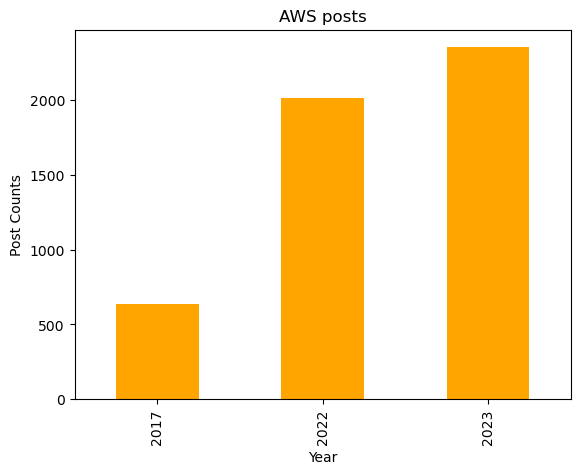

In [17]:
df_aws['fullmessage'].groupby(pd.to_datetime(df_aws['utc_datetime_str']).dt.year).count().plot(kind="bar",color='orange')
plt.title('AWS posts')
plt.ylabel('Post Counts')
plt.xlabel('Year')

Text(0.5, 0, 'Year')

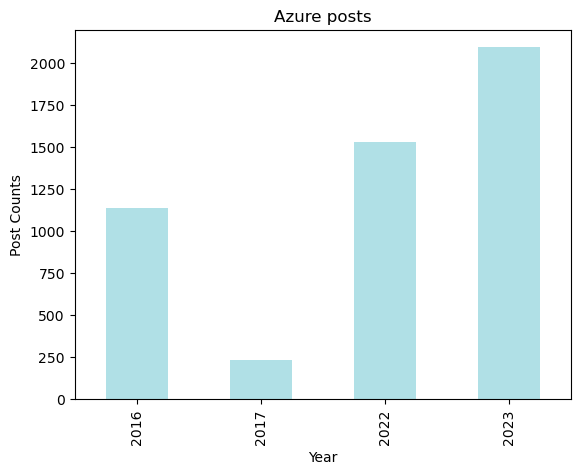

In [18]:
df_az['fullmessage'].groupby(pd.to_datetime(df_az['utc_datetime_str']).dt.year).count().plot(kind="bar",color='powderblue')
plt.title('Azure posts')
plt.ylabel('Post Counts')
plt.xlabel('Year')

In [19]:
df_aws[df_aws['text_word_count'] <2]

,subreddit,selftext,author,title,score,num_comments,utc_datetime_str,fullmessage,text_length,text_word_count
91,aws,[removed],Jade12_CM,Question?,1,0,2023-03-08 11:08:21,Question,8,1
580,aws,[removed],Acrobatic-Emu8229,Cloud9,1,0,2023-02-22 18:04:14,Cloud,5,1
685,aws,[removed],New-Comfortable-5912,Help,1,0,2023-02-18 17:38:53,Help,4,1
930,aws,[removed],TechGeekMica,Capacity,1,0,2023-02-12 04:41:49,Capacity,8,1
1073,aws,[removed],maedo,botocore.awsrequest.AWSRequest object,1,0,2023-02-07 18:48:22,object,6,1
1080,aws,NaN,094459,https://dev.to/aws/aws-open-source-newsletter-144-22h,1,0,2023-02-07 13:22:36,,0,0
1187,aws,[removed],Altruistic-Fish-1510,Question,1,0,2023-02-03 20:26:27,Question,8,1
1411,aws,NaN,Express-Cartoonist-6,Hhh,1,0,2023-01-28 17:32:12,Hhh,3,1
1418,aws,NaN,Dingydongu,help,1,0,2023-01-28 10:43:26,help,4,1
1826,aws,NaN,tus72,Issue #31,1,0,2023-01-17 11:08:44,Issue,5,1


In [20]:
df_az[df_az['text_word_count'] <2]

,subreddit,selftext,author,title,score,num_comments,utc_datetime_str,fullmessage,text_length,text_word_count
175,AZURE,NaN,ggddgdseh,Azure,1,0,2023-03-05 18:38:29,Azure,5,1
2156,AZURE,http://f88ff.Wordpress.com,Kitchen_Recipe_2848,404,1,0,2022-12-28 14:17:14,,0,0
2866,AZURE,NaN,Kanetheamerican,Twitch,1,0,2022-11-29 18:19:09,Twitch,6,1
2946,AZURE,[removed],Erys19_,Powerbi,1,0,2022-11-26 01:04:55,Powerbi,7,1
3577,AZURE,[removed],Beautiful-Relief1004,https://new-google-apps.blogspot.com/2022/11/filmorago-video-editor-maker-mod-apk.html,1,0,2022-11-06 11:16:06,,0,0
3590,AZURE,[removed],Beautiful-Relief1004,https://new-google-apps.blogspot.com/2022/11/download-bowmasters-mod-unlimited-coins.html,1,0,2022-11-05 09:10:08,,0,0
3612,AZURE,[removed],Beautiful-Relief1004,https://new-google-apps.blogspot.com/2022/11/download-kingdom-wars-mod-unlimited.html,1,0,2022-11-04 14:35:16,,0,0
3934,AZURE,NaN,azeddineazeddine,hghkk,0,3,2016-12-15 10:41:09,hghkk,5,1
4988,AZURE,[deleted],[deleted],Blog retired...,5,0,2016-04-17 19:34:55,Blog,4,1


Text(0.5, 0, 'Number of words in post')

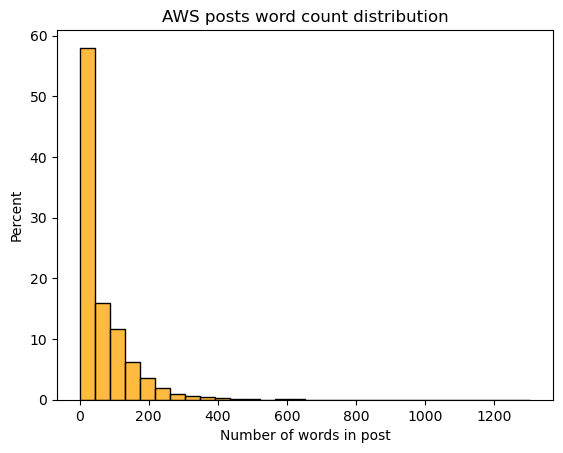

In [21]:
plt.title('AWS posts word count distribution')
sns.histplot(data=df_aws, x="text_word_count", kde=False, bins=30, color='orange',stat='percent')
plt.xlabel('Number of words in post')

Text(0.5, 0, 'Number of words in post')

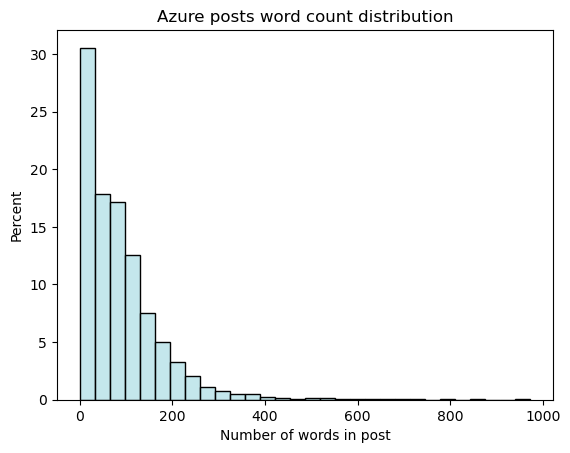

In [22]:
plt.title('Azure posts word count distribution')
sns.histplot(data=df_az, x="text_word_count", kde=False, bins=30, color='powderblue',stat='percent')
plt.xlabel('Number of words in post')

In [23]:
df_aws['text_word_count'].describe()

count    4998.000000
mean       60.448579
std        80.625134
min         0.000000
25%         8.000000
50%        19.000000
75%        90.000000
max      1305.000000
Name: text_word_count, dtype: float64

In [24]:
df_az['text_word_count'].describe()

count    4996.000000
mean       86.975781
std        87.447249
min         0.000000
25%        18.000000
50%        67.000000
75%       120.000000
max       973.000000
Name: text_word_count, dtype: float64

### Remove rows <= 2 words

In [25]:
df_aws = df_aws[df_aws['text_word_count'] > 2]
df_az = df_az[df_az['text_word_count'] > 2]

df_aws.shape

(4911, 10)

In [26]:
df_az.shape

(4971, 10)

### Define functions for word vectorising and visualising top words

* Get word vectors from data frame column
* Plot top words from word vector

In [27]:
def get_word_vectors(df_col,n_gram):
    """
    Get word vectors from dataframe column:
    df_col : column of data frame
    n_gram: maximum number of word group
    For Count Vectoriser:
    max_df = 100 means "ignore terms that appear in more than 100 documents".
    min_df = 3 means "ignore terms that appear in less than 3 documents"
    """
    cv = CountVectorizer(stop_words='english', min_df=3,ngram_range=n_gram)
    cv.fit(df_col)
    df_cv = cv.transform(df_col)
    result = pd.DataFrame(df_cv.todense(), columns=cv.get_feature_names_out())
    return result

In [28]:
def plot_top_grams(df,x_label,y_label,title,top,n_grams):
    """
    Plot top words based on word vectors
    df: Dataframe
    x_label: x axis name
    y_label: y axis name
    title: chart title name
    top: Number of top words
    n_grams: maximum group of words
    """
    series = get_word_vectors(df['fullmessage'],(n_grams,n_grams))
    plt.ylabel(y_label)    
    plt.xlabel(x_label)
    plt.title(title)
    data = series.sum().sort_values(ascending=False).head(top).sort_values()
    threshold = data.quantile(0.75)
    colors = ['lightcoral' if count > threshold else 'lightsteelblue' for count in data]
    data.plot(kind='barh',color=colors)
    plt.grid(axis = 'x')
    plt.savefig(f'../images/{title}_cv.jpg', bbox_inches='tight')
    plt.show()

In [29]:
def get_tfidf_vectors(df_col,n_gram):
    """
    Get word vectors from dataframe column:
    df_col : column of data frame
    n_gram: maximum number of word group
    """
    tvec = TfidfVectorizer(stop_words='english', min_df=3,ngram_range=n_gram)
    tvec.fit(df_col)
    df_tvec = tvec.transform(df_col)
    result = pd.DataFrame(df_tvec.todense(), columns=tvec.get_feature_names_out())
    return result

In [30]:
def plot_top_tfidf(df,x_label,y_label,title,top,n_grams):
    """
    Plot top words based on TFIDF word vectors
    df: Dataframe
    x_label: x axis name
    y_label: y axis name
    title: chart title name
    top: Number of top words
    n_grams: maximum group of words
    """
    series = get_tfidf_vectors(df['fullmessage'],(n_grams,n_grams))
    plt.ylabel(y_label)    
    plt.xlabel(x_label)
    plt.title(title)
    data = series.sum().sort_values(ascending=False).head(top).sort_values()
    threshold = data.quantile(0.75)
    colors = ['springgreen' if count > threshold else 'gainsboro' for count in data]
    data.plot(kind='barh',color=colors)
    plt.grid(axis = 'x')
    plt.savefig(f'../images/{title}_tfidf.jpg', bbox_inches='tight')
    plt.show()

In [31]:
def plot_mid_tfidf(df,x_label,y_label,title,mid,n_grams):
    """
    Check if vectorised words are still meaningful after a certain rank e.g. 5000
    df: Dataframe
    x_label: x axis name
    y_label: y axis name
    title: chart title name
    top: Number of top words
    n_grams: maximum group of words
    """
    series = get_tfidf_vectors(df['fullmessage'],(1,n_grams))
    plt.ylabel(y_label)    
    plt.xlabel(x_label)
    plt.title(title)
    data = series.sum().sort_values(ascending=False)[mid:mid+20]
    data.plot(kind='barh',color='grey')
    plt.grid(axis = 'x')
    plt.savefig(f'../images/{title}_check.jpg', bbox_inches='tight')
    plt.show()

In [32]:
def generate_wordcloud(data, mask=None):
    """
    Function to plot word cloud 
    data: text string for word cloud
    mask: image to shape the word cloud
    """
    cloud = WordCloud(scale=3,
                      max_words=1000,
                      max_font_size=500,
                      mask=mask,
                      background_color='white',
                      stopwords=stopwords,
                      collocations=True,
                      random_state=42).generate_from_text(str(data))
    plt.figure(figsize=(50,40))
    plt.imshow(cloud)
    plt.axis('off')
    return plt

### Visualise top words
* Compare emphasised words from engineered from Count Vectoriser and TF-IDF vectorisers

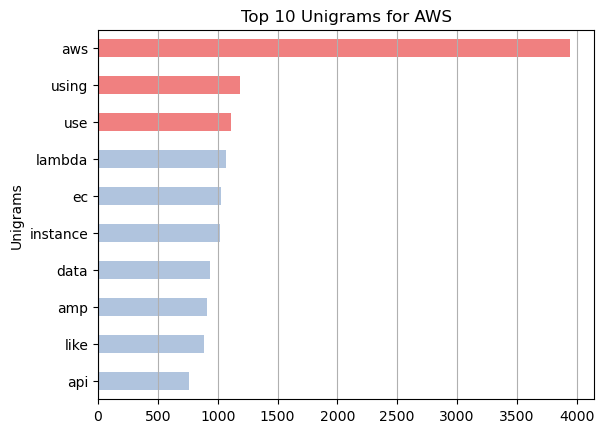

In [33]:
plot_top_grams(df_aws,'Occurrence','Unigrams','Top 10 Unigrams for AWS',10,1)

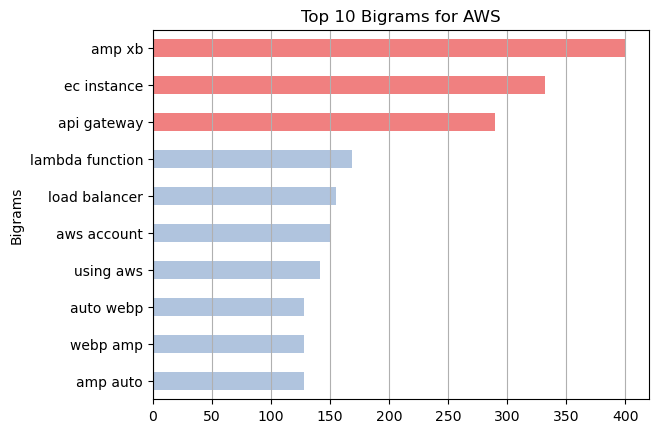

In [34]:
plot_top_grams(df_aws,'Occurrence','Bigrams','Top 10 Bigrams for AWS',10,2)

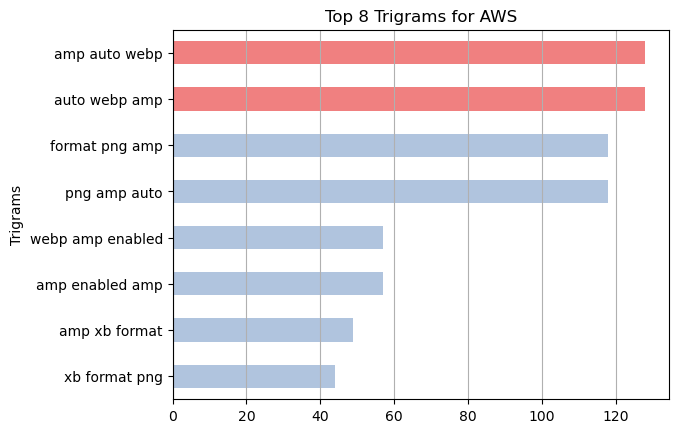

In [35]:
plot_top_grams(df_aws,'Occurrence','Trigrams','Top 8 Trigrams for AWS',8,3)

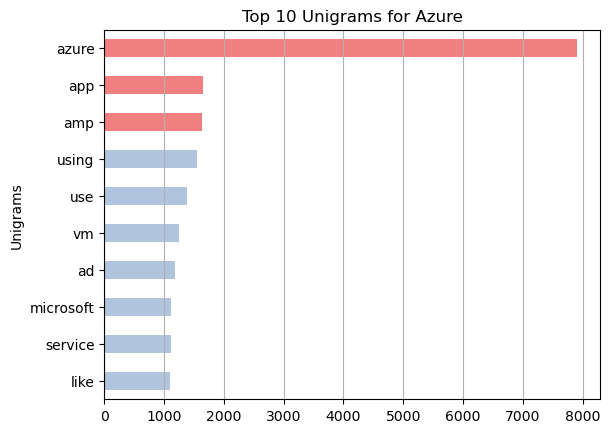

In [36]:
plot_top_grams(df_az,'Occurrence','Unigrams','Top 10 Unigrams for Azure',10,1)

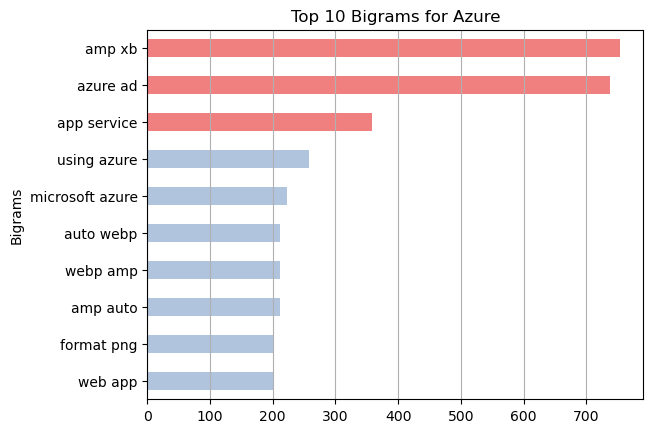

In [37]:
plot_top_grams(df_az,'Occurrence','Bigrams','Top 10 Bigrams for Azure',10,2)

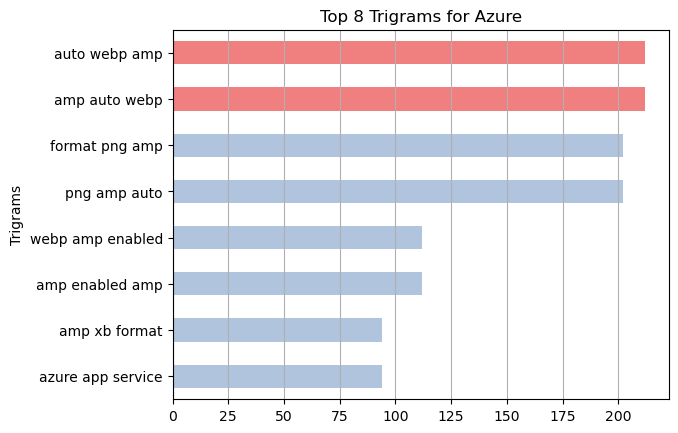

In [38]:
plot_top_grams(df_az,'Occurrence','Trigrams','Top 8 Trigrams for Azure',8,3)

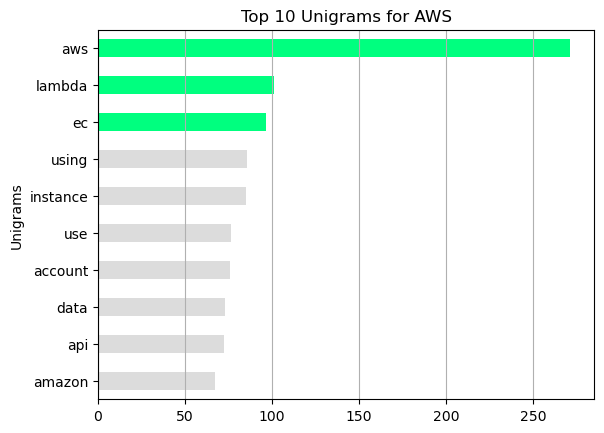

In [39]:
plot_top_tfidf(df_aws,'Occurrence','Unigrams','Top 10 Unigrams for AWS',10,1)

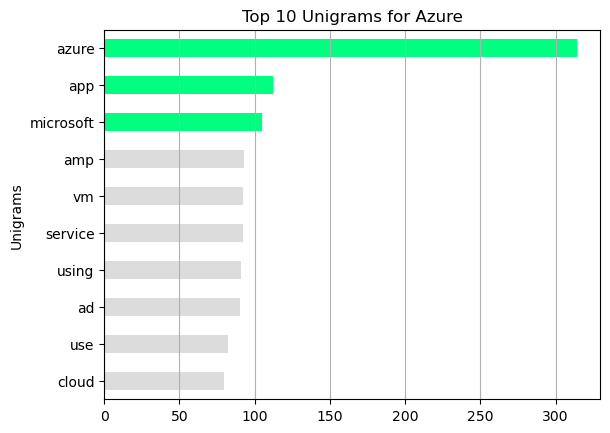

In [40]:
plot_top_tfidf(df_az,'Occurrence','Unigrams','Top 10 Unigrams for Azure',10,1)

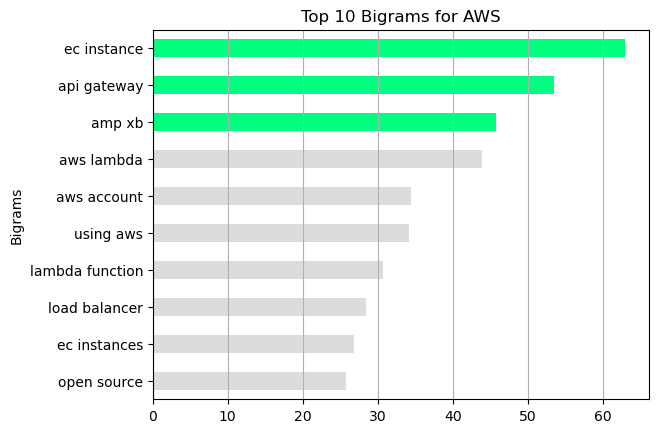

In [41]:
plot_top_tfidf(df_aws,'Occurrence','Bigrams','Top 10 Bigrams for AWS',10,2)

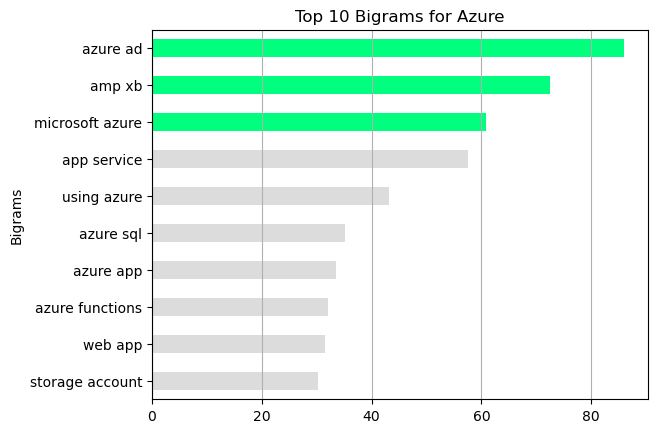

In [42]:
plot_top_tfidf(df_az,'Occurrence','Bigrams','Top 10 Bigrams for Azure',10,2)

### Combine dataset into single dataframe
* Checks if special characters are cleaned from the text

In [43]:
def investigate(df_col,word):
    """
    Function to check if word still exist in the dataframe columns
    """
    matched_list = [text for text in df_col if word in text.lower()]
    print(matched_list[:10])

In [44]:
investigate(df_aws['fullmessage'],'&amp')

[]


In [45]:
investigate(df_az['fullmessage'],'&amp')

[]


In [46]:
df = pd.concat([df_aws,df_az])
df.shape

(9882, 10)

### Visualise the top words in combined data set

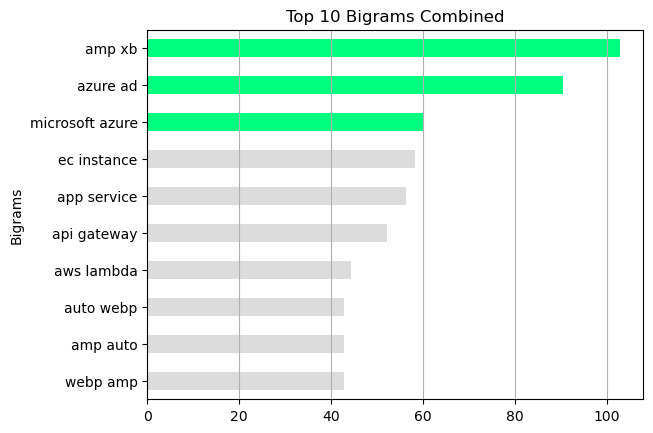

In [47]:
plot_top_tfidf(df,'Occurrence','Bigrams','Top 10 Bigrams Combined',10,2)

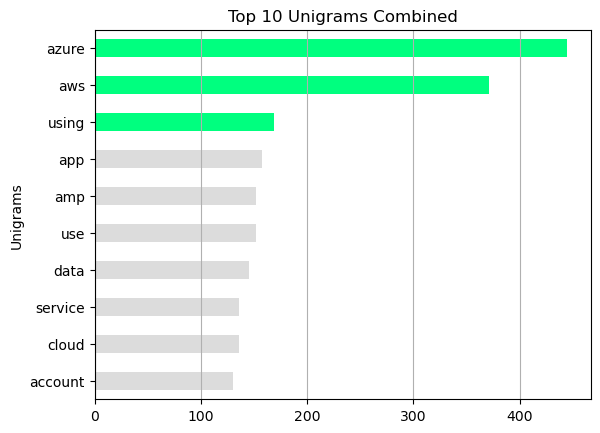

In [48]:
plot_top_tfidf(df,'Occurrence','Unigrams','Top 10 Unigrams Combined',10,1)

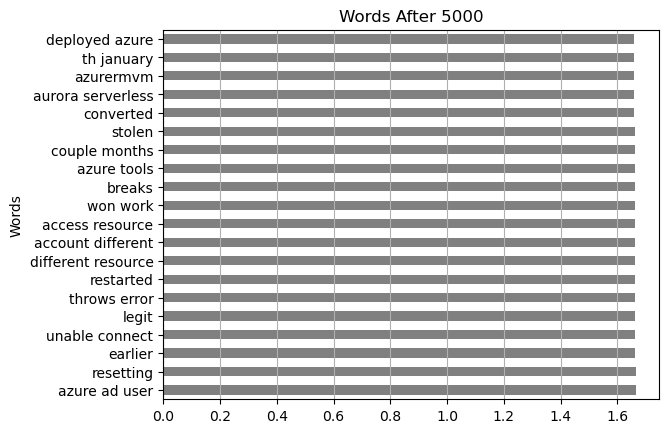

In [49]:
plot_mid_tfidf(df,'Occurrence','Words','Words After 5000',5000,3)

### Visualise the word cloud of the cleaned data set

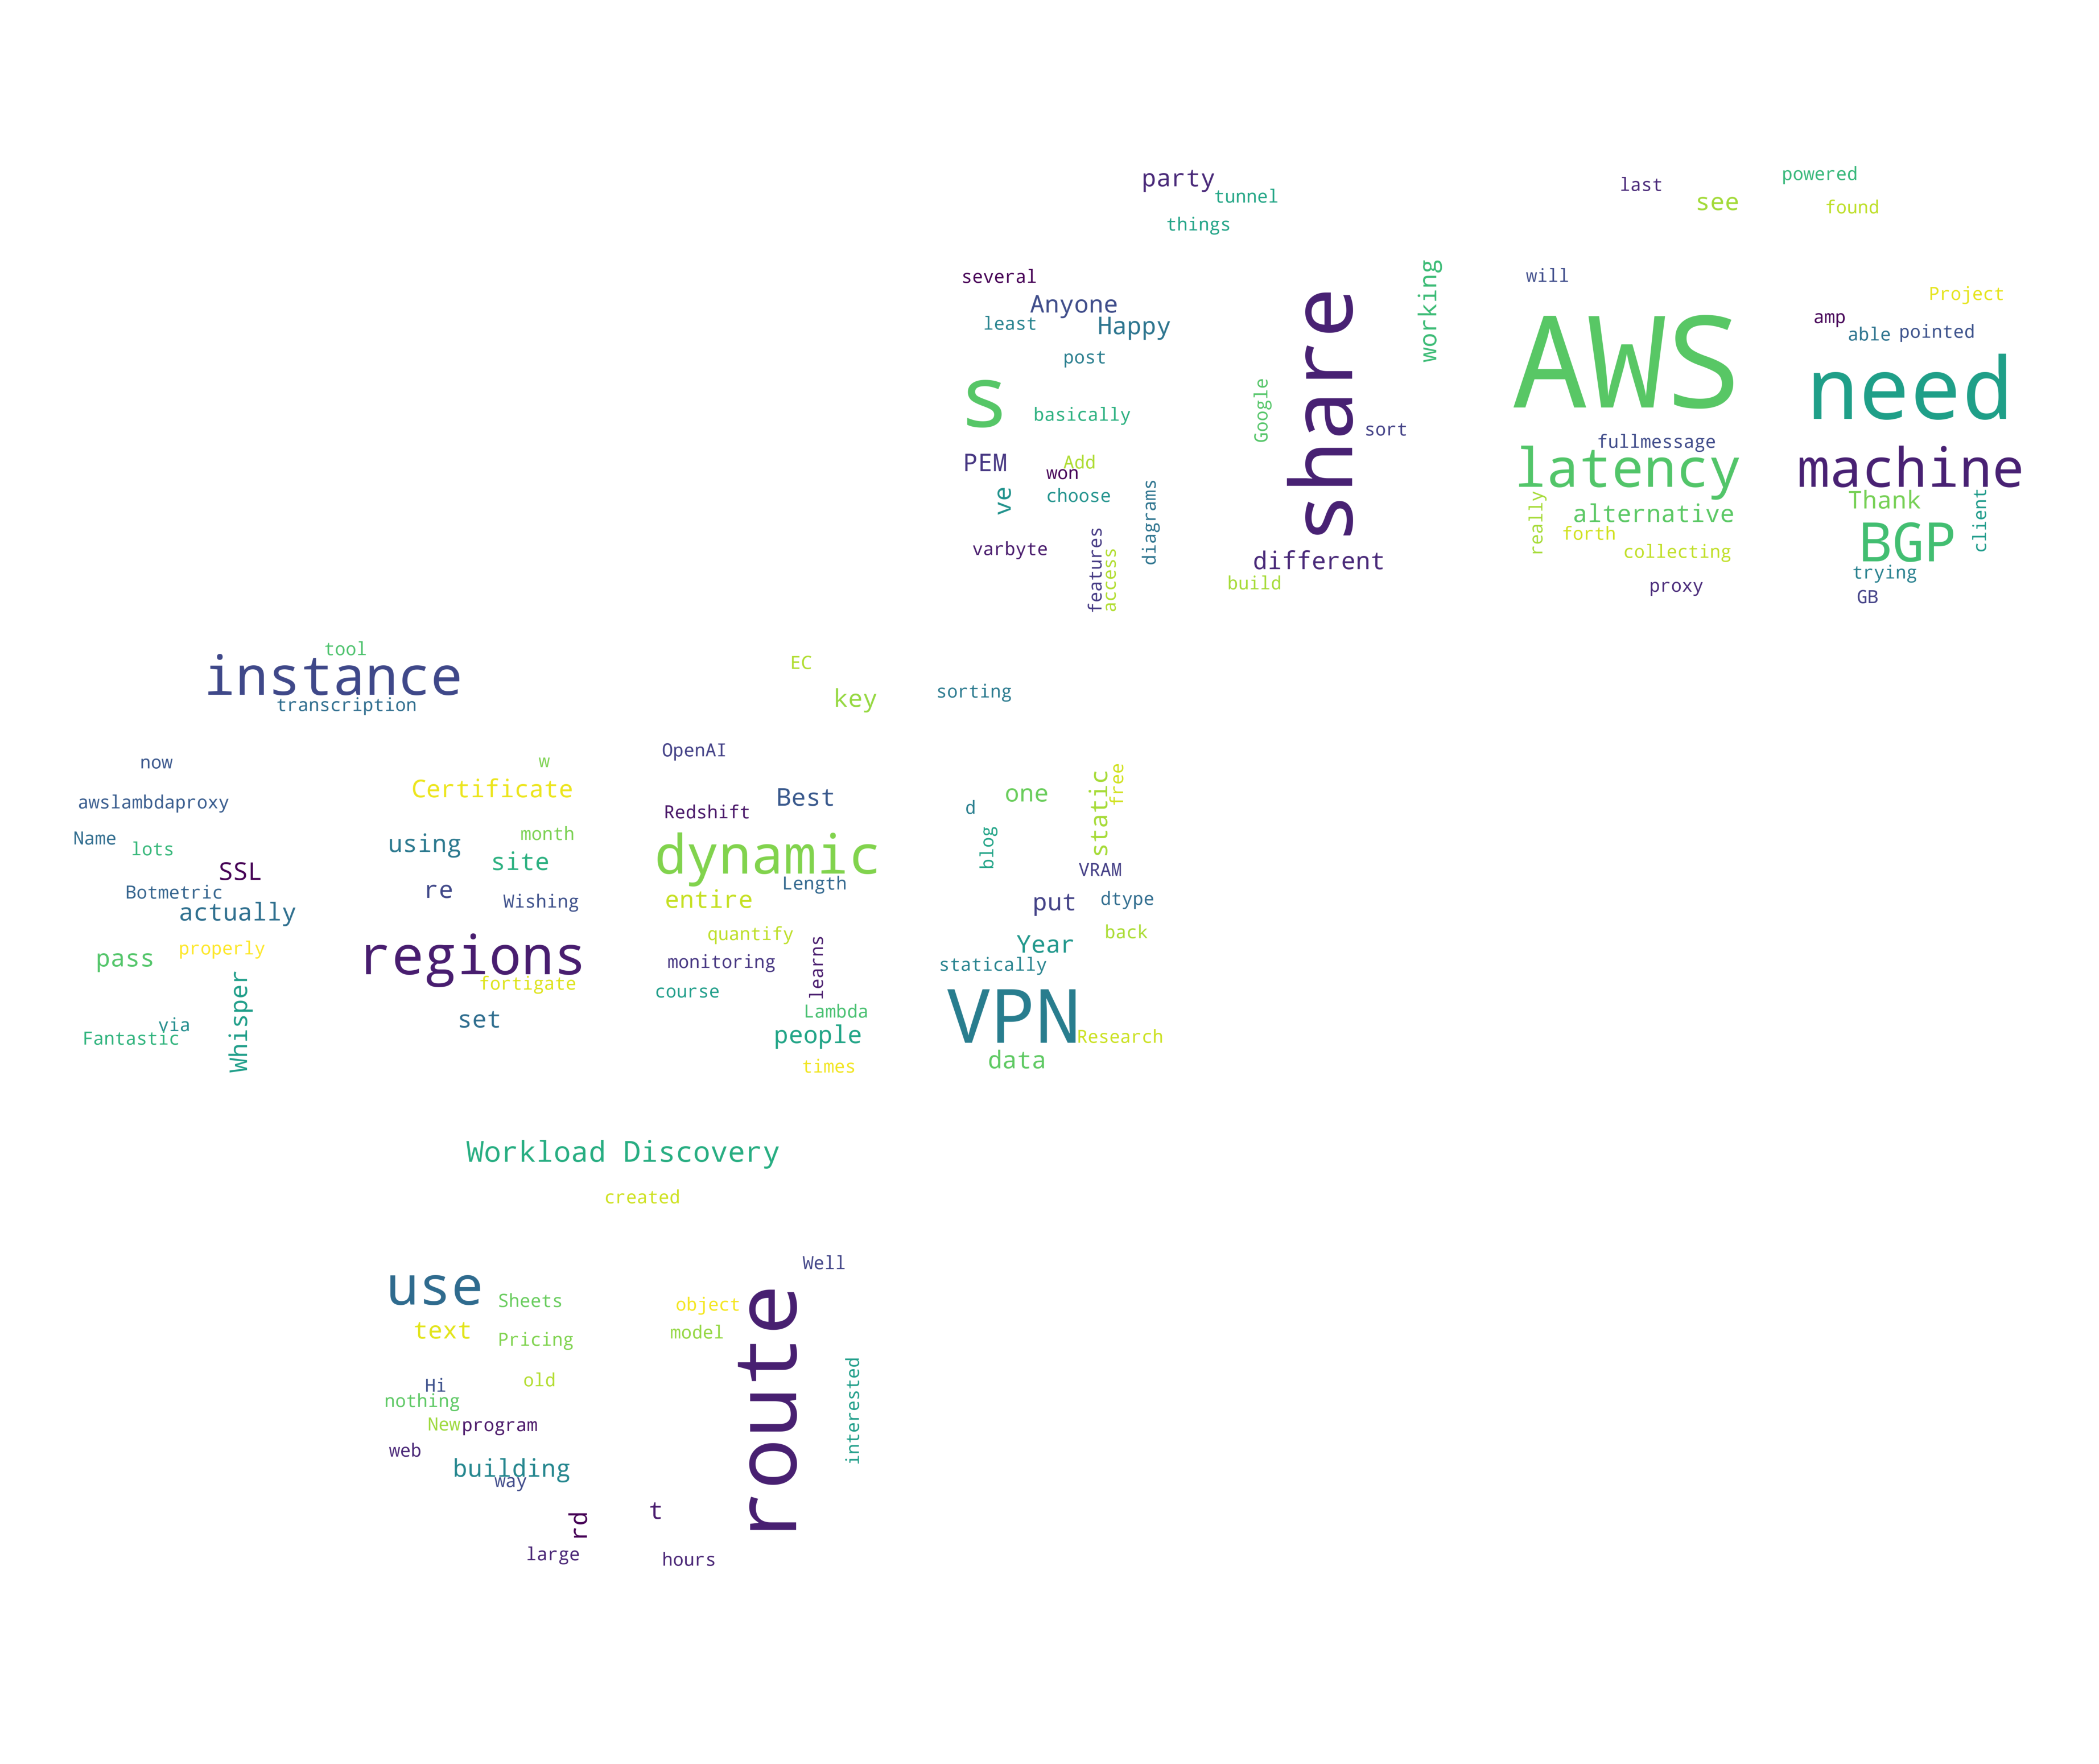

In [50]:
mask = np.array(Image.open('../images/aws.png'))
plt_aws_wc = generate_wordcloud(
    df[df['subreddit']=='aws']['fullmessage'], 
    mask=mask)
plt_aws_wc.savefig('../images/aws_wc.png')
plt_aws_wc.show()

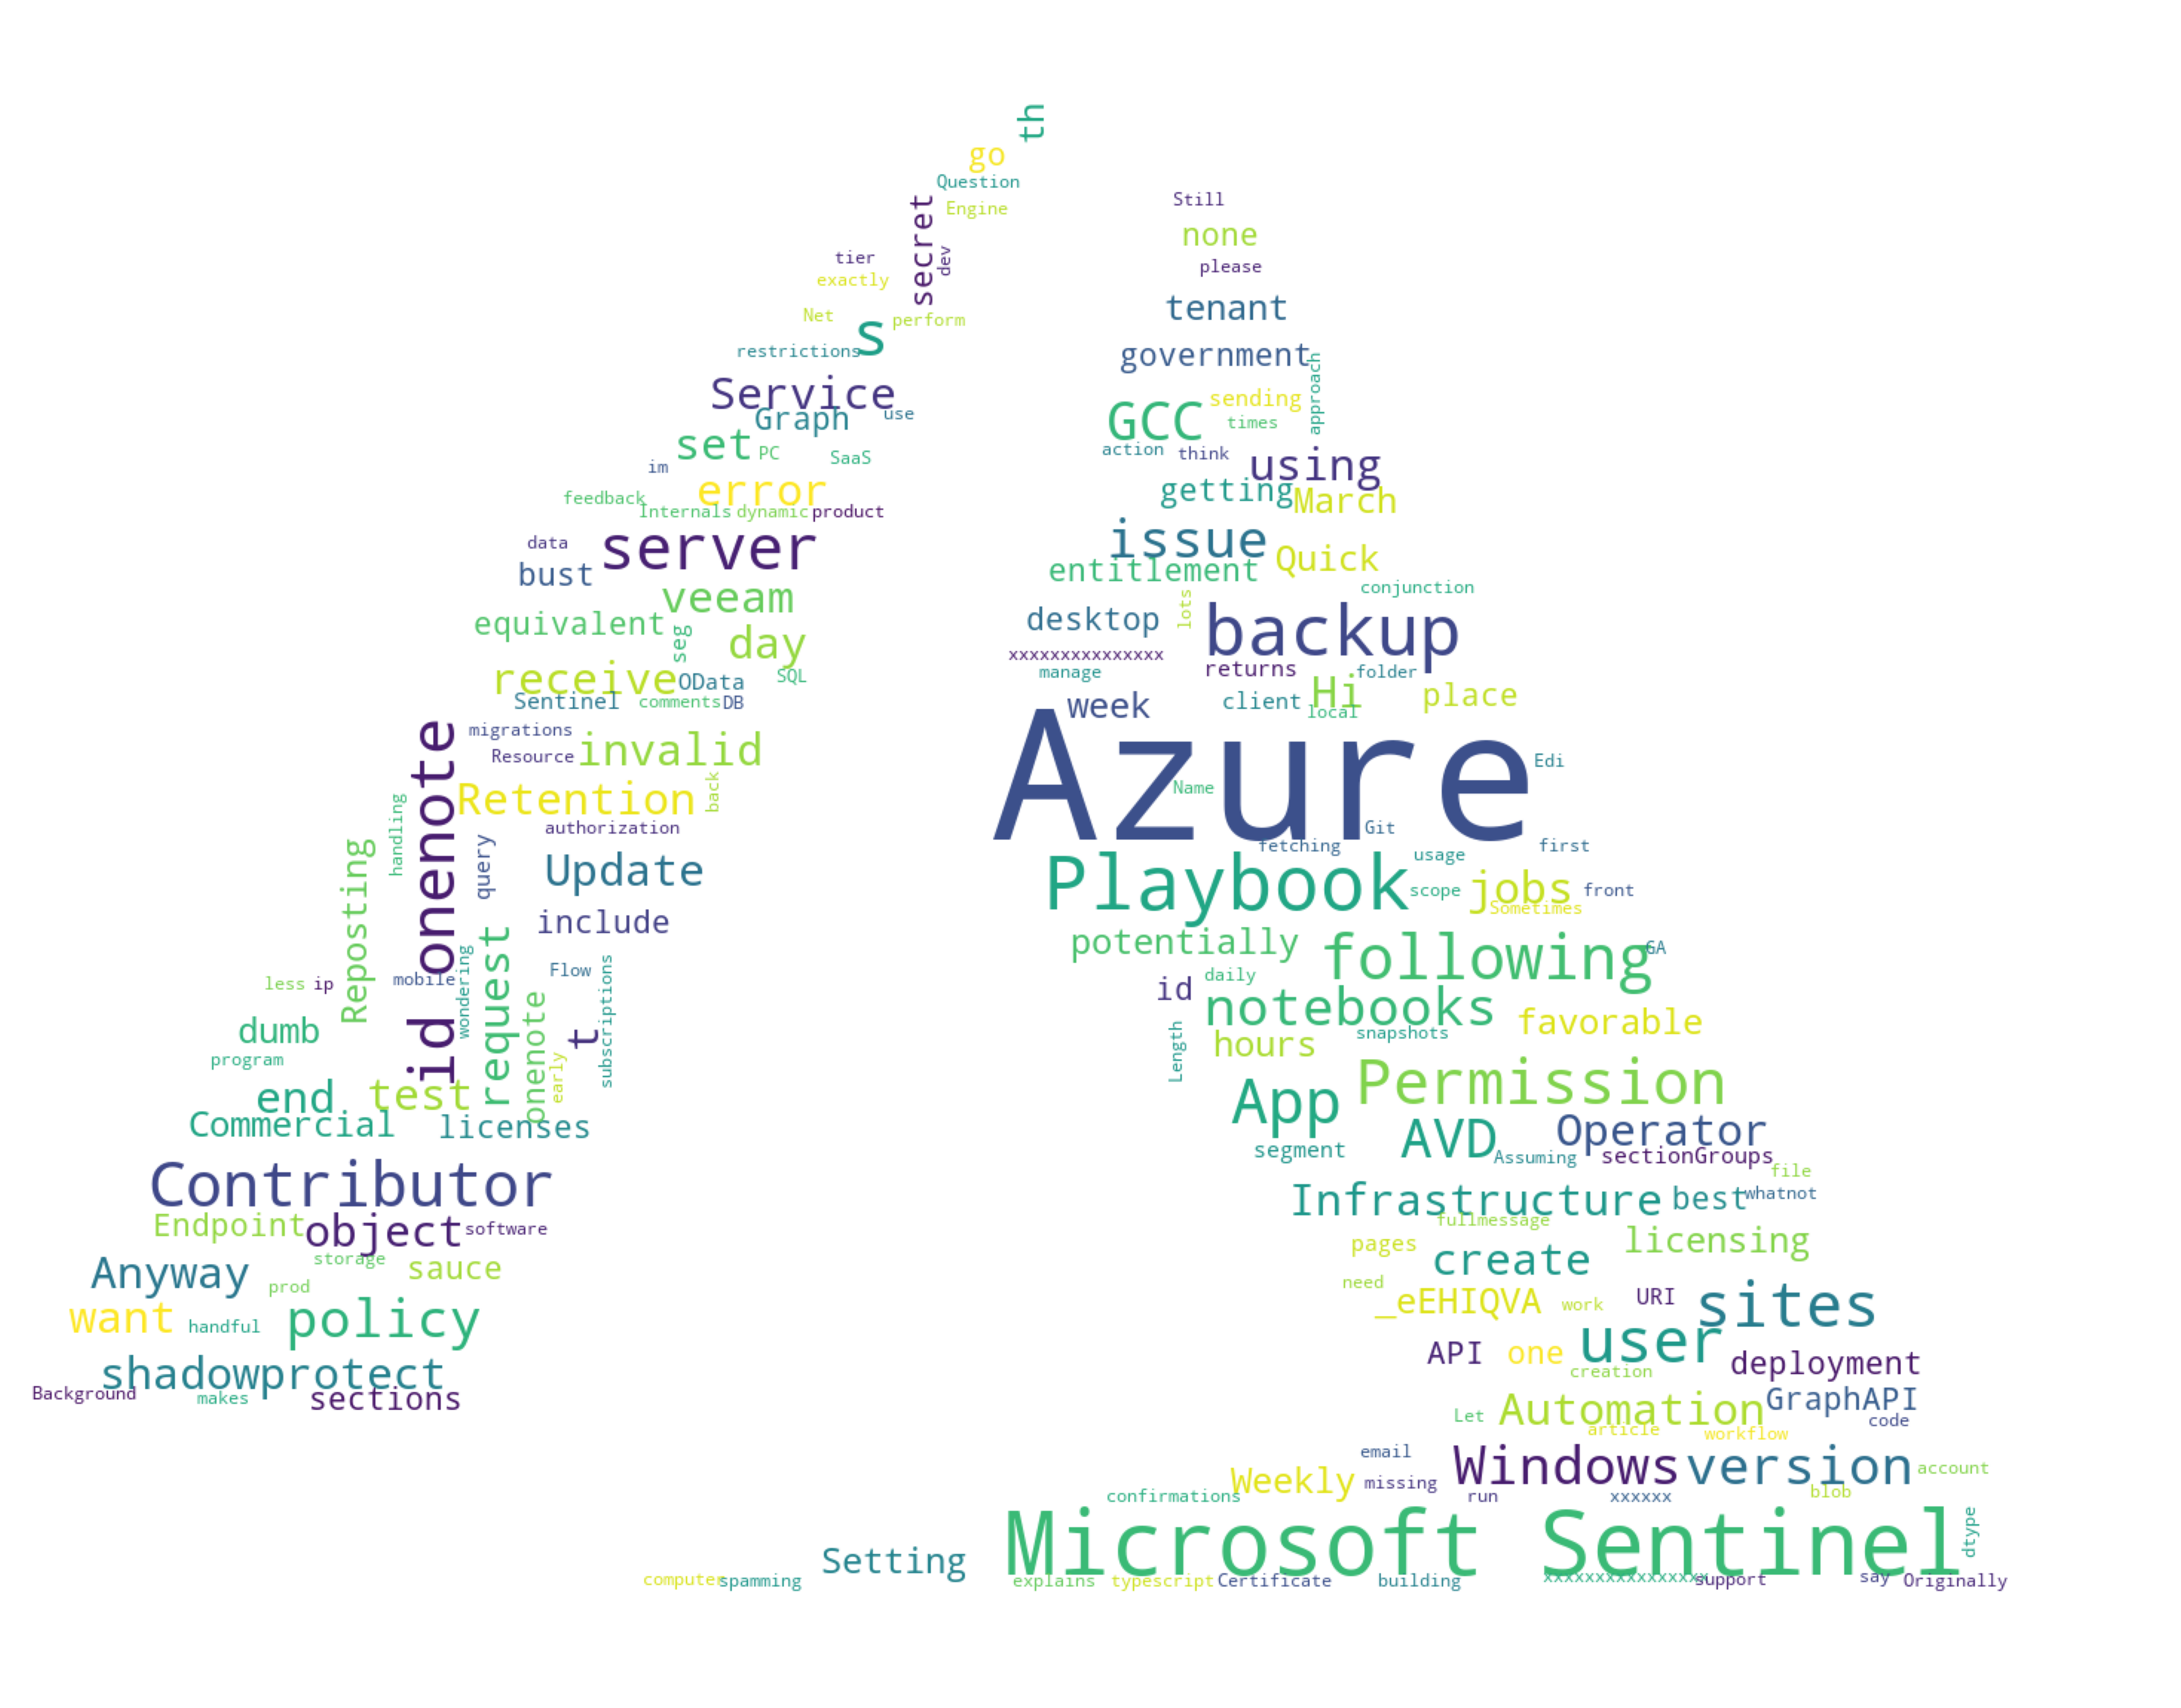

In [51]:
mask = np.array(Image.open('../images/azure.png'))
plt_az_wc = generate_wordcloud(df[df['subreddit']=='AZURE']['fullmessage'],mask)
plt_az_wc.savefig('../images/az_wc.png')
plt_az_wc.show()

In [52]:
df.subreddit.value_counts()

AZURE               4971
aws                 4905
u_Cloudvisor-AWS       6
Name: subreddit, dtype: int64

In [53]:
df = df[(df['subreddit']=='aws') | (df['subreddit']=='AZURE')]
df.shape

(9876, 10)

### Explore dataset using spacy scatter text plots
* Code is commented out as it takes some time to run

In [54]:
#spacy.cli.download("en_core_web_sm")
#en_core_web_sm = spacy.load('en_core_web_sm')
#corpus = CorpusFromPandas(df,
#                          category_col='subreddit',
#                          text_col='fullmessage',
#                          nlp=en_core_web_sm).build()

In [55]:
#type(corpus)

In [56]:
#html = produce_scattertext_html(corpus,
#                                    category='aws',
#                                    category_name='aws',
#                                    not_category_name='AZURE',
#                                    minimum_term_frequency=5,
#                                    width_in_pixels=1000)
#open('./simple.html', 'wb').write(html.encode('utf-8'))
#print('Open ./simple.html in Chrome or Firefox.')

### Preparing Data for Model training

This sections prepares the dataset for training from choosing the relevant columns into X and y (target) from the combined dataset we get from the csv file above.

* 0 for subreddit AWS
* 1 for subreddit AZURE

New features will be generated aside from the word vectors from the "fullmessage" column
* has comments
* score
* word_count
* post_age

Saved the clean data into a csv file for model training

In [57]:
def word_exist(text, key_words):    
    return any(i in text.lower() for i in key_words)

In [58]:
df['contain_aws'] = df['fullmessage'].apply(lambda x: 1 if word_exist(x, ['amazon', 'aws']) else 0)
df['contain_az'] = df['fullmessage'].apply(lambda x: 1 if word_exist(x, ['microsoft', 'azure']) else 0)

In [59]:
df['timestamp']= pd.to_datetime(df['utc_datetime_str'])

In [60]:


def diff_days(post_date):
    now = datetime.datetime.now()
    delta = now - post_date
    return delta.days

df['post_age_days']=df['timestamp'].apply(lambda x: diff_days(x))
df.head(2)

,subreddit,selftext,author,title,score,num_comments,utc_datetime_str,fullmessage,text_length,text_word_count,contain_aws,contain_az,timestamp,post_age_days
0,aws,[removed],BrianPRegan,AWS Pricing Add-on for Google Sheets,1,0,2023-03-10 16:28:11,AWS Pricing Add on for Google Sheets,36,7,1,0,2023-03-10 16:28:11,8
2,aws,"We have a site to site VPN between our AWS and a fortigate. It's set to dynamic so BGP shares all the routes back and forth.\n\nWell there is one route that I can't get it to share over BGP. I have put it as a route statically in AWS and pointed it to the AWS tunnel but it won't pass.\n\nIf a aws VPN is set the ""dynamic"" will it only pass routes it learns via BGP? You can't add a static also?",silicondt,VPN - dynamic - can we put one static also?,1,0,2023-03-10 15:20:34,VPN dynamic can we put one static also We have a site to site VPN between our AWS and a fortigate It s set to dynamic so BGP shares all the routes back and forth Well there is one route that I can t get it to share over BGP I have put it as a route statically in AWS and pointed it to the AWS tunnel but it won t pass If a aws VPN is set the dynamic will it only pass routes it learns via BGP You...,420,96,1,0,2023-03-10 15:20:34,9


In [61]:
df['has_comments']=df['num_comments'].apply(lambda x: 1 if x>=1 else 0 )
df['target'] = df['subreddit'].map({'aws':1, 'AZURE':0})

### Drop columns 
* without aws or azure classification mapped
* null

In [62]:
df[df['target'].isna()]

,subreddit,selftext,author,title,score,num_comments,utc_datetime_str,fullmessage,text_length,text_word_count,contain_aws,contain_az,timestamp,post_age_days,has_comments,target


In [63]:
df.dropna(subset=['target'],inplace=True)
df['target'].value_counts()

0    4971
1    4905
Name: target, dtype: int64

In [64]:
df['target']=df['target'].astype(int)

### Double check if any special character remains in the post

In [65]:
invalid_char_list = ['\#','\{','\}','\\']

df['contain_invalid_char'] = df['fullmessage'].apply(lambda x: 1 if word_exist(x, invalid_char_list) else 0)

In [66]:
df.columns

Index(['subreddit', 'selftext', 'author', 'title', 'score', 'num_comments',
       'utc_datetime_str', 'fullmessage', 'text_length', 'text_word_count',
       'contain_aws', 'contain_az', 'timestamp', 'post_age_days',
       'has_comments', 'target', 'contain_invalid_char'],
      dtype='object')

In [67]:
df['contain_invalid_char'].value_counts()

0    9876
Name: contain_invalid_char, dtype: int64

In [68]:
df[df['contain_invalid_char']==1]

,subreddit,selftext,author,title,score,num_comments,utc_datetime_str,fullmessage,text_length,text_word_count,contain_aws,contain_az,timestamp,post_age_days,has_comments,target,contain_invalid_char


In [69]:
df.isna().sum()

subreddit                  0
selftext                1817
author                     0
title                      0
score                      0
num_comments               0
utc_datetime_str           0
fullmessage                0
text_length                0
text_word_count            0
contain_aws                0
contain_az                 0
timestamp                  0
post_age_days              0
has_comments               0
target                     0
contain_invalid_char       0
dtype: int64

### Save the cleaned data into csv file

In [70]:
# df.to_csv('..\data\data_clean_2.csv')